In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#connect to poloniex public api
polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1356998100&end=9999999999&period=86400'
eth_df = pd.read_json(polo_url)
eth_df = eth_df.set_index('date')

In [3]:
eth_df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08,1.40,0.33,0.500000,0.33,176.539438,274.003968,1.552084
2015-08-09,1.40,1.40,1.400000,1.40,0.000000,0.000000,1.400000
2015-08-10,1.40,1.40,1.400000,1.40,0.000000,0.000000,1.400000
2015-08-11,1.10,1.14,0.550000,0.66,251.517082,242.975973,0.966042
2015-08-12,1.38,1.40,0.900001,1.05,404.344781,476.807211,1.179210


In [4]:
eth_df.describe()

,close,high,low,open,quoteVolume,volume,weightedAverage
count,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1.283000e+03,1283.000000
mean,206.388451,215.308732,195.309697,206.260664,24555.670844,5.622752e+06,205.415127
std,268.370581,281.141276,252.286182,268.345974,43937.212241,1.137560e+07,266.931851
min,0.429691,0.330000,0.005000,0.330000,0.000000,0.000000e+00,0.439825
25%,10.394299,10.666239,9.805000,10.349025,3111.776296,4.546344e+04,10.318964
50%,88.455218,91.210000,84.528166,87.650000,8425.154551,8.640245e+05,88.003357
75%,306.996098,318.200000,293.432373,306.900050,27459.425809,5.330856e+06,304.327051
max,1382.000000,1424.000000,1264.000000,1382.000000,427541.821839,9.151612e+07,1354.371792


In [5]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1283 entries, 2015-08-08 to 2019-02-10
Data columns (total 7 columns):
close              1283 non-null float64
high               1283 non-null float64
low                1283 non-null float64
open               1283 non-null float64
quoteVolume        1283 non-null float64
volume             1283 non-null float64
weightedAverage    1283 non-null float64
dtypes: float64(7)
memory usage: 80.2 KB


In [6]:
#discard and define new data
eth_df['hi_lo_pct'] = (eth_df['high'] - eth_df['low'])/(eth_df['low']*100)
eth_df['pct_change'] = (eth_df['close'] - eth_df['open'])/(eth_df['open']*100)
eth_df = eth_df[['close', 'hi_lo_pct', 'pct_change', 'volume']]
eth_df.tail()

,close,hi_lo_pct,pct_change,volume
date,,,,
2019-02-06,104.493650,0.000600,-0.000271,6.077724e+05
2019-02-07,104.263000,0.000217,-0.000018,2.745901e+05
2019-02-08,119.226740,0.001942,0.001427,1.116383e+06
2019-02-09,119.673624,0.000313,0.000068,6.665771e+05
2019-02-10,116.881490,0.000352,-0.000216,2.533178e+05


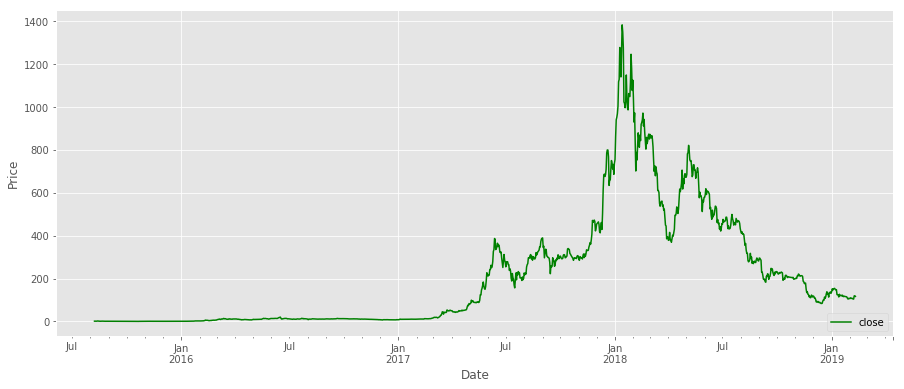

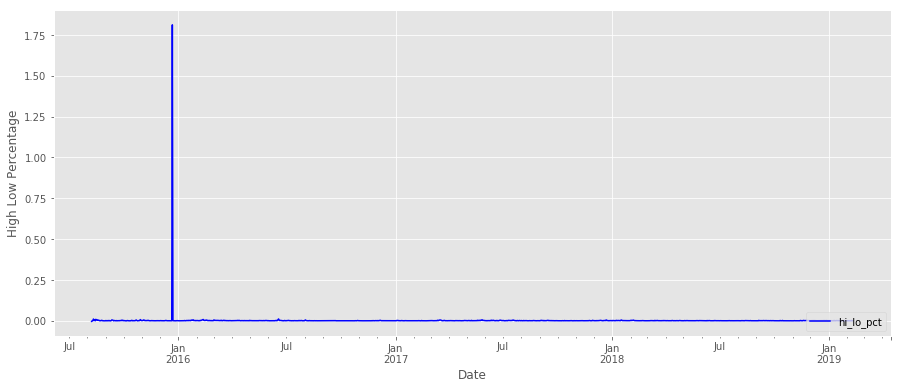

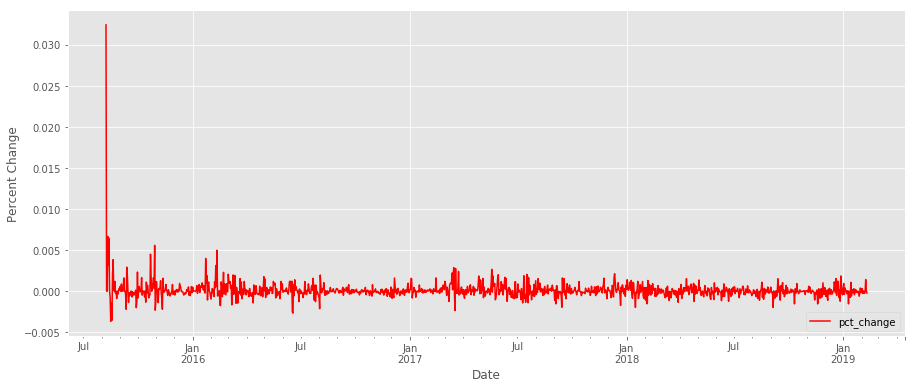

In [7]:
#visualize
eth_df['close'].plot(figsize=(15,6), color='green')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
eth_df['hi_lo_pct'].plot(figsize=(15,6), color='blue')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()
eth_df['pct_change'].plot(figsize=(15,6), color='red')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

In [8]:
eth_df.describe()

,close,hi_lo_pct,pct_change,volume
count,1283.000000,1283.000000,1283.000000,1.283000e+03
mean,206.388451,0.002487,0.000102,5.622752e+06
std,268.370581,0.050569,0.001196,1.137560e+07
min,0.429691,-0.003400,-0.003672,0.000000e+00
25%,10.394299,0.000447,-0.000257,4.546344e+04
50%,88.455218,0.000759,0.000000,8.640245e+05
75%,306.996098,0.001330,0.000326,5.330856e+06
max,1382.000000,1.811997,0.032424,9.151612e+07


In [9]:
#remove outliers with IQR
def remove_outlier(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)

  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)

  out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return out_df


In [10]:
eth_df = remove_outlier(eth_df, 'hi_lo_pct')
eth_df = remove_outlier(eth_df, 'pct_change')
eth_df.describe()

,close,hi_lo_pct,pct_change,volume
count,1109.000000,1109.000000,1109.000000,1.109000e+03
mean,211.300675,0.000779,0.000005,4.439742e+06
std,266.028767,0.000498,0.000409,8.190017e+06
min,0.429691,0.000000,-0.001049,0.000000e+00
25%,10.600000,0.000407,-0.000238,4.963822e+04
50%,93.450000,0.000671,-0.000012,8.376818e+05
75%,314.500000,0.001047,0.000236,4.565340e+06
max,1382.000000,0.002647,0.001092,6.927351e+07


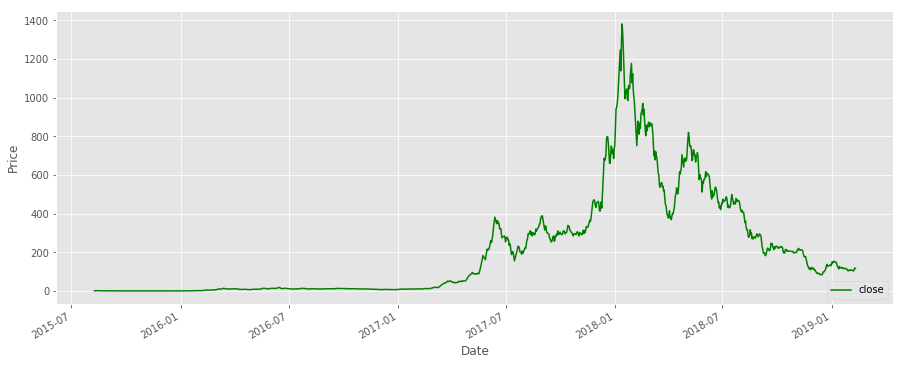

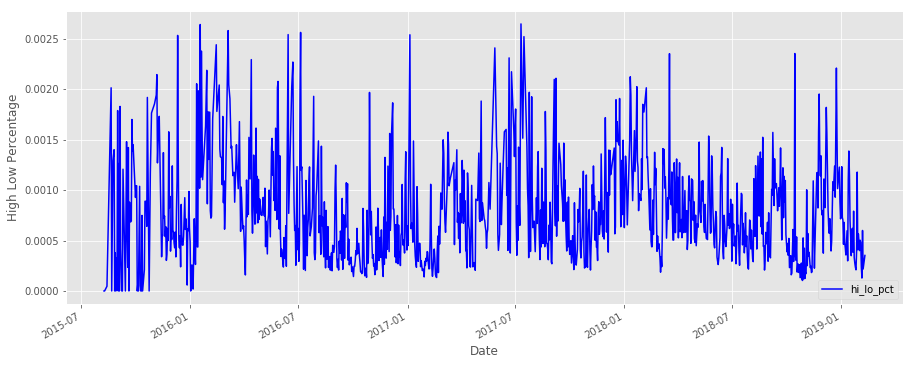

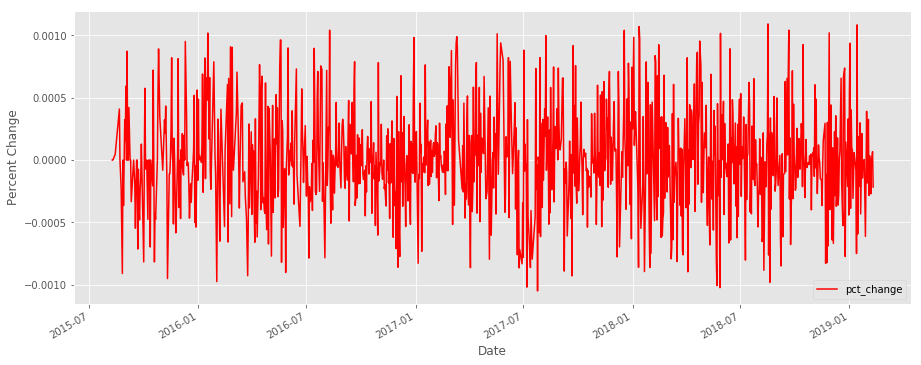

In [11]:
#re-visualize
eth_df['close'].plot(figsize=(15,6), color='green')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
eth_df['hi_lo_pct'].plot(figsize=(15,6), color='blue')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()
eth_df['pct_change'].plot(figsize=(15,6), color='red')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

In [12]:
#create forcast column
forecast_col = 'close'
#forecast 30 days ahead
forecast_out = int(30)
print('length =',len(eth_df), "and forecast_out =", forecast_out)

length = 1109 and forecast_out = 30


In [13]:
#create output column
eth_df['label'] = eth_df[forecast_col].shift(-forecast_out)

In [14]:
# standardize data 
X = np.array(eth_df.drop(['label'],1))
X = preprocessing.scale(X)
print(X[1,:])

[-0.78937093 -1.56694842 -0.01318578 -0.54233647]


In [15]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 30 & Length of X : 1079


In [16]:
# define Label vector y for the data we have prediction for
y = np.array(eth_df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

Length of y:  1079


In [17]:
# cross validation split into test and train data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

In [18]:
print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  863 216


In [19]:
# train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
#show accuracy of model on test data
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.7474284863424605


In [20]:
# predict
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[121.85531509 125.57397794  90.25131468 114.67957956 101.91971799
 123.33729879 122.76207084 118.00403934 120.82812679 110.49668256
 117.15780951 111.55372858 116.57349002 120.37488175 122.47429137
 121.25334019 112.09312485  85.19324628 108.73045753 115.21471259
 106.59410766 111.90334713 113.10915539 104.28848265 115.5593845
 117.04532452 102.6271476  113.92584395 126.27684805 115.39116326]


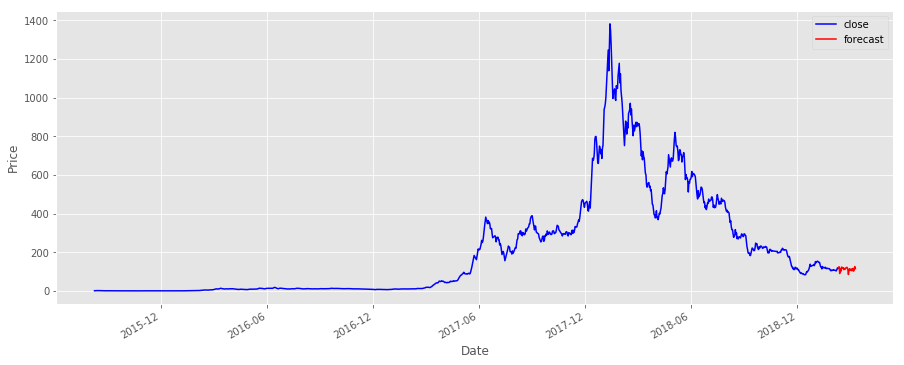

In [21]:
#add predicted dates to df
eth_df['forecast'] = np.nan
last_date = eth_df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    eth_df.loc[next_date] = [np.nan for _ in range(len(eth_df.columns)-1)]+[i]
    
# Plot data    
eth_df['close'].plot(figsize=(15,6), color="blue")
eth_df['forecast'].plot(figsize=(15,6), color="red")
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

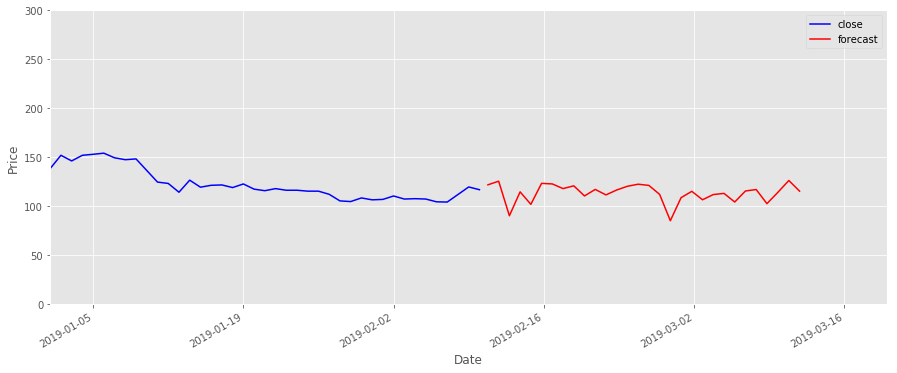

In [22]:
#zoom in on forecast
eth_df['close'].plot(figsize=(15,6), color="blue")
eth_df['forecast'].plot(figsize=(15,6), color="red")
plt.xlim(xmin=datetime.date(2019, 1, 1), xmax = datetime.date(2019, 3, 20) )
plt.ylim(ymin=0, ymax=300)
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [35]:
print('Price for last 5 days:')
print(eth_df['close'][-35:-30])
print('Price for next 5 days')
print(eth_df['forecast'][-30:-25])

Price for last 5 days:
date
2019-02-05    107.334260
2019-02-06    104.493650
2019-02-07    104.263000
2019-02-09    119.673624
2019-02-10    116.881490
Name: close, dtype: float64
Price for next 5 days
date
2019-02-10 19:00:00    121.855315
2019-02-11 19:00:00    125.573978
2019-02-12 19:00:00     90.251315
2019-02-13 19:00:00    114.679580
2019-02-14 19:00:00    101.919718
Name: forecast, dtype: float64
